# Theory behind R-L algorithm

Let's take a step back and consider of the nature of the signal that we are dealing with.

We know that light is emitted, arrives at and is detected by our digital photographic sensors not in a continuous fashion but discretely,
as described by Poisson statistics. In other words for photons emitted by a stable light source arriving on the area of a pixel at a rate that
would result in an average of 5.2 photoelectrons per exposure, the number of counts actually captured by such a pixel during each such exposure
is not a constant 5.2 but it has a probability of achieving a given count according to the integer distribution known as a
Poisson Distribution.

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 150

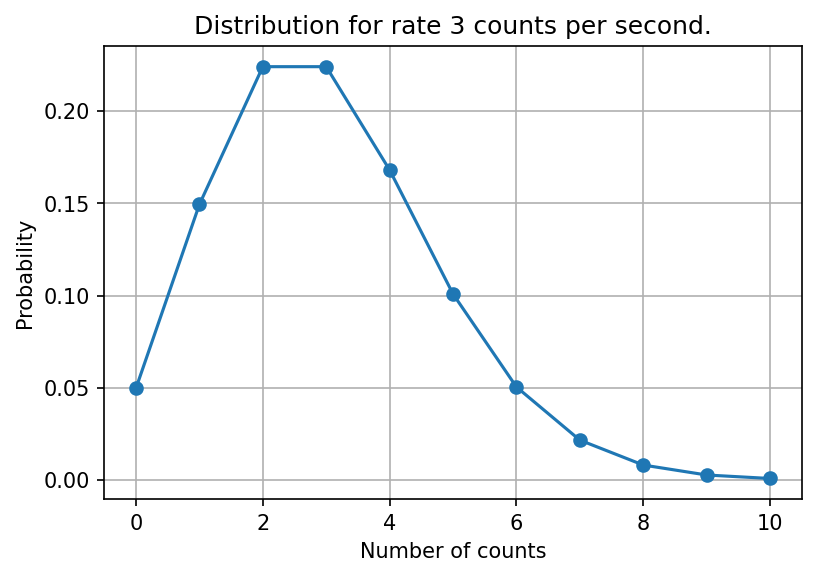

In [2]:
import numpy as np
from scipy.stats import poisson

x = np.arange(0, 11)
y = poisson.pmf(x, 3)

plt.title("Distribution for rate 3 counts per second.")
plt.plot(x, y, marker="o")
plt.xlabel("Number of counts")
plt.ylabel("Probability")
plt.grid(True)

With exposure resulting in $\lambda$ photoelectrons per pixel on average,
the probability $p$ that a given pixel will collect $i$ counts during exposure is:

$$
p(i) = e^{-\lambda} \frac{\lambda^i}{i!}
$$

The problem that we will be solving here is finding a $\lambda$ based on the observed count.
Intuitively it is obvious that if we look at a single pixel in isolation the answer could literally be anything so in that case the problem does not have a well defined solution. But if we have more than one pixel we can start making more probable educated guesses, the more the pixels the more probably accurate the guesses.

The probability of two independent events occurring is the product of their individual probabilities.
Using the equation presented above we can calculate the probability that the value $i$ recorded by each pixel in the image file refers to a estimated $\lambda$ associated with it. 

The joint probability over the whole image $P(I)$ ) (remember it is a SCALAR) is the product of the individual pixel probabilities $p(i)$.

$$
P(I) = \prod e^{-\Lambda} \frac{\Lambda^{I}}{I!}
$$

In other words, probability that the result obtained from the sensor will be $I$ is equal to the product of all pixel probabilities in a matrix
given by the expression on the right side of $\prod$. In that expression $\Lambda$ and all operations all element wise.

What we want to do is to find such matrix $\Lambda$ to maximize the probability matrix $P(I)$.

In order to do this let's derive a method to to do this. First we will simplify the equation by taking a logarythm from both sides. 
We can do this because the maxima of a surface and their logarithm coincide, as do their minima.  With logarithms exponents become factors and products become sums so now we need to maximize this simpler equation instead:

$$
ln(P(I)) = - \sum (\Lambda - I\text{ln}(\Lambda) + ln(I!))
$$

The job is to vary our estimated uncorrupted image $\Lambda$ until $P(I)$ is maximized, meaning that there is maximum chance that captured image data $I$ is a consequence of it. This is called Maximum Likelihood Estimation.

Since we notice that the last term in the equation is a constant offset that does not vary with
$\Lambda$, it does not affect when the maximum occurs so we can drop it.

$$
ln(P(I)) = - \sum (\Lambda - I \text{ln}(\Lambda))
$$

Finally we can notice that we can drop minus from this equation and minimize the "unlikelyhood".

So to sum up we need to minimize the following function since if this will have a minimum value then also argument of logarithm will have a minimu value:

$$
J(\Lambda) = \sum (\Lambda - I \text{ln}(\Lambda))
$$

There is however a problem because we know that the received image $I$ is also subjected tp the blurring by the point spread function $H$
For that reason we need to replace the image without the poisson noise $\Lambda$ with convolution of of image without the noise and blurr $O$
with a point spread fuction $H$.

$$
J(O) = \sum (O*H - I \text{ln}(O*H))
$$

Now to find the minimum of the above function first we compute it's gradient:

The gradient of our cost function can be expressed as:

$$
\nabla J(O) =  \left[ 1 - \frac{I}{O * H} \right] * H^T
$$

T means adjugate matrix of point spread function $H$. This is a determinant of the matrix multiplied by it's inverse.

$$
H^T = \text{det}(H)H^{-1}
$$

Then we can exploit the fact that $J(O)$ is a convex function which means that minimum value of this function is in the place where $\nabla J(O) = 0$.

So in other words we have to solve the following equation:

$$
0 = \left[ 1 - \frac{I}{O * H} \right] * H^T
$$

We can then exploit some properties of convolution and get this:

$$
1 = \frac{I}{O * H} * H^T
$$

Unfortunately the closed form solution does not really exist. So let's try to invent iterative process in which we can find the matrix $O$ that will satisfy
the above equation.

To do this first we will investigate a gradient descent process. The gradient descent process that minimizes the loss function $J(O)$ is expressed by the following formula:

$$
O_{k+1} = O_k - \alpha \nabla J(O_k)
$$

Where alpha is some small number that determines how fast we descend. If alpha is sufficiently small then at each iteration we are getting closer to the solution.
As the gradient descent progresses, the gradient will approach zero. It is important to note that that next value is obtained in fact by shifting the current value by a small amount in the direction opposite to the gradient.

If we look at the equation $1 = \frac{I}{O * H} * H^T$ we can see that as we approach solution term $\frac{I}{O * H} * H^T$ will approach 1.

Now let's investigate what happens to the value of $\frac{I}{O * H} * H^T$ as we vary the $O$. If $O$ is growing the value of the term will decrease. If will decrease
the value of $O$ then the value of the term will increase. That gives us an opportunity to come up with a very clever way to approximate the solution by means of gradient descent but without all troubles with finding a right $\lambda$.

To explain how we can do this let's investigate what happens when we multiply the $\frac{I}{O * H} * H^T$ by the current value $O_k$.
If $O_k$ is to high, $\frac{I}{O * H} * H^T$ will be smaller than 1 so the result of the multiplication will be smaller.
If $O_k$ is to low then the $\frac{I}{O * H} * H^T$ will be larger than 1 so the result of the multiplication will be larger than the current value of $O_k$.
Also as $O_k$ approaches solution, the changes will become smaller as  $\frac{I}{O * H} * H^T$ will converge to 1.

This very simple thinking results in a formula for Richardson Lucy deconvolution:

$$
O_{k+1} = O_k\left[ \frac{I}{O_k * H} * H^T \right]
$$

# Implementation

Now let's implement richardson lucy deconvolution:

In [3]:
from scipy.ndimage.filters import convolve
from tqdm import tqdm

def rl(raw_image, psf, niter):
    
    # Normalize PSF.
    psf /= psf.sum()
    
    # Magic proerties involved here,
    # We can compute H^T in this way.
    psf_adjug = psf[::-1]
    
    # Initialize O to the mean of the image.
    lucy = np.ones( raw_image.shape ) * raw_image.mean()

    for i in tqdm(range(niter)):
        # Convolve estimate wth the point spread function.
        estimate = convolve(lucy, psf, mode='mirror')
        estimate[np.isnan(estimate)] = 0
        
        # Divide raw image by estimate and convolve with the adjugate
        correction = convolve(raw_image/estimate, psf_adjug, mode='mirror')
        correction[np.isnan(correction)] = 0
        
        # Multiply to get the next value.
        lucy *= correction
        
    return lucy

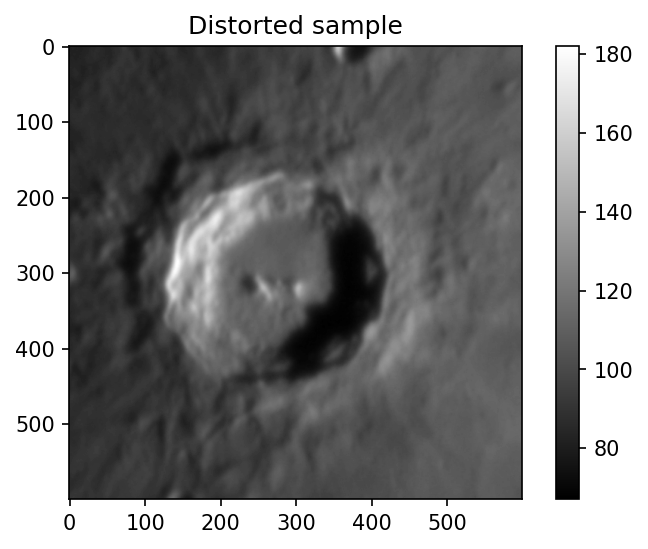

In [4]:
sample = cv2.imread("../samples/crater.png", cv2.IMREAD_GRAYSCALE)
plt.title("Distorted sample")
plt.imshow(sample, cmap='gray')
plt.colorbar()
#plt.savefig('3_distorted.png', dpi=300)

In [5]:
import scipy.stats as st

def gkern(kernlen=27, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

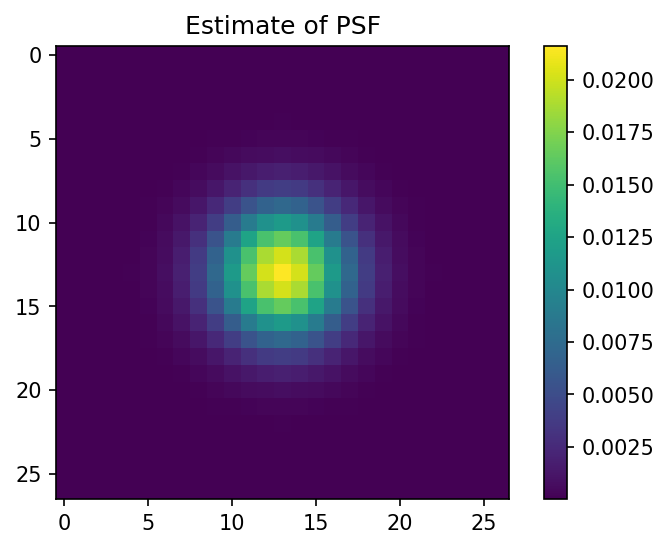

In [6]:
psf = gkern(27, 5.0)
plt.title("Estimate of PSF")
plt.imshow(psf)
plt.colorbar()
#plt.savefig('3_psf.png', dpi=300)

In [11]:
estimate = rl(sample, psf, 100)

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


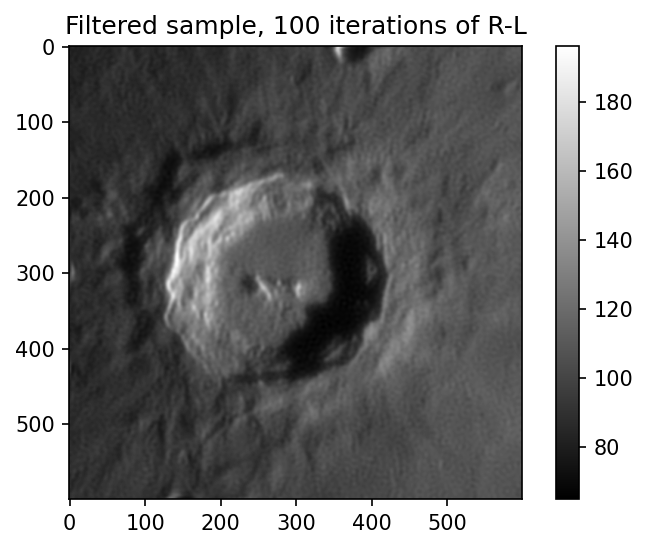

In [12]:
plt.title("Filtered sample, 100 iterations of R-L")
plt.imshow(estimate, cmap='gray')
plt.colorbar()
#plt.savefig('3_filtered.png', dpi=300)